In [1]:
#July 13
"""
Starting to look for a general LF for many wavelengths (Optical and UV).
"""

import ares
import numpy as np
import matplotlib.pyplot as pl

In [2]:
data = ares.analysis.GalaxyPopulation() #for lit values
pop_halo = ares.populations.HaloPopulation()


### Star-forming galaxies
good approximation to generate their spectra assuming they’ve been forming stars at a constant rate for quite awhile. 

In [5]:
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(pop_sed='eldridge2009', pop_tsf=12)

pop = ares.populations.GalaxyPopulation(**base_pars)

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z020


C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\analysis\GalaxyPopulation.py:1259: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Emma\Anaconda3\lib\site-packages\numpy\ma\core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
C:\Users\Emma\Anaconda3\lib\site-packages\numpy\core\_asarray.py:138: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Emma\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


# WARNING: finkelstein2015 wavelength=1500.0A, not 1600.0A!
# WARNING: parsa2016 wavelength=1500.0A, not 1600.0A!
# WARNING: weisz2014 wavelength=1700.0A, not 1600.0A!
# WARNING: vanderburg2010 wavelength=1500.0A, not 1600.0A!


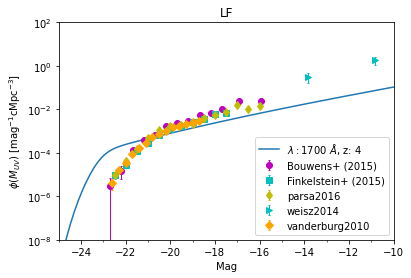

In [6]:
Lambda = 1700
z = 4
mags = np.linspace(-25, 10, 200)

LF = pop.Gen_LuminosityFunction(z, mags, Lambda)
lable = '$\lambda: ${} $\AA$, z: {}'.format(Lambda, z)
pl.semilogy(mags, LF, label=lable)

data.Plot(z=4, round_z=0.5)

pl.ylabel('$\phi(M_{UV})$ [mag$^{-1}$cMpc$^{-3}$]')
pl.xlabel('Mag')
pl.title('LF')

pl.ylim(1e-8,1e2)
pl.xlim(-25,-10)
pl.legend()

pl.show()

In [4]:
def getParams(z):

    logM_0 = 11.88 #(0.01)
    mu = 0.019 #(0.002)
    N_0 = 0.0282 #(0.0003)
    nu = -0.72 #(0.06)
    gamma_0 = 0.556 #0.001
    gamma_1 = -0.26 #(0.05)
    beta_0 = 1.06 #(0.06)
    beta_1 = 0.17 #(0.12)

    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0*(z+1)**mu)
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
    
    return N, M_1, beta, gamma

$L_{per SFR}(\lambda) \cdot SFR(z, Hm) = Lum_{\lambda} $   [erg/s/Hz], for a given wavelength $\lambda$   
then we need to bin the Lum to get $\phi(M_{\lambda})$ [mag$^{-1}$cMpc$^{-3}$], this is done by:

$\frac{dM_h}{dLum_{\lambda}} \cdot \frac{dn}{dM_h} = \phi(M_{\lambda})$, but I'll need to get $\frac{dM_h}{dLum_{\lambda}}$ numerically.    

In [5]:
#differential for binning
def dL_dM(z, Lum, Hm):
    
    diff = []
    for i in range(len(Lum)-1):
        diff.append( (Lum[i+1] - Lum[i])/(Hm[i+1] - Hm[i]) )
        
    return diff

def Gen_LF(z, Lambda, LumType='Mag'):
    Lsun = ares.physics.Constants.lsun

    Hm = pop_halo.halos.tab_M

    Lum = pop.src.L_per_sfr(Lambda) * 10**pop.SFR(z, Hm, True, log10=False) #[erg/s/Hz]
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    dndM = pop_halo.halos.tab_dndm[k, :][:-1]

    if LumType == 'Lum':
        dLdM = dL_dM(z, Lum, Hm)  
        xVals = Lum

    elif LumType == 'Mag':
        MagSys = ares.util.MagnitudeSystem()
        mag = MagSys.L_to_MAB(Lum, z=z)

        dLdM = np.abs(dL_dM(z, mag, Hm))
        xVals = mag
    else:
        print("Not a value unit for luminosity, choose either Mag or Lum")
        dLdM = -np.inf
        xVals = np.zeros(len(Lum))
    
    LF = dndM/dLdM

    return xVals[:-1], LF

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z020
# WARNING: finkelstein2015 wavelength=1500.0A, not 1600.0A!
# WARNING: parsa2016 wavelength=1500.0A, not 1600.0A!
# WARNING: weisz2014 wavelength=1700.0A, not 1600.0A!
# WARNING: vanderburg2010 wavelength=1500.0A, not 1600.0A!


C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\analysis\GalaxyPopulation.py:1259: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Emma\Anaconda3\lib\site-packages\numpy\ma\core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
C:\Users\Emma\Anaconda3\lib\site-packages\numpy\core\_asarray.py:138: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Emma\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


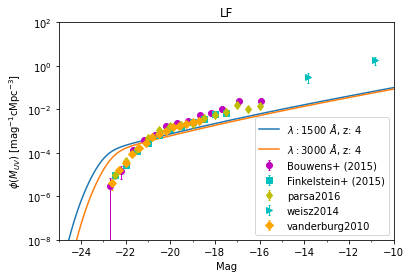

In [6]:
Lambda = 1500
z = 4

x, LF = Gen_LF(z, Lambda)
lable = '$\lambda: ${} $\AA$, z: {}'.format(Lambda, z)
pl.semilogy(x, LF, label=lable)

x, LF = Gen_LF(z, 3000)
lable = '$\lambda: ${} $\AA$, z: {}'.format(3000, z)
pl.semilogy(x, LF, label=lable)

data.Plot(z=4, round_z=0.5)

pl.ylabel('$\phi(M_{UV})$ [mag$^{-1}$cMpc$^{-3}$]')
pl.xlabel('Mag')
pl.title('LF')

pl.ylim(1e-8,1e2)
pl.xlim(-25,-10)
pl.legend()

pl.show()

C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\analysis\GalaxyPopulation.py:1259: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


# WARNING: parsa2016 wavelength=1500.0A, not 1600.0A!
# WARNING: alavi2016 wavelength=1500.0A, not 1600.0A!
# WARNING: reddy2009 wavelength=1700.0A, not 1600.0A!


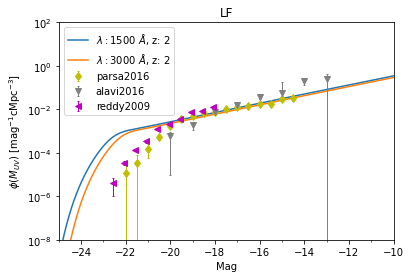

In [16]:
Lambda = 1500
z = 2

x, LF = Gen_LF(z, Lambda)
lable = '$\lambda: ${} $\AA$, z: {}'.format(Lambda, z)
pl.semilogy(x, LF, label=lable)

x, LF = Gen_LF(z, 3000)
lable = '$\lambda: ${} $\AA$, z: {}'.format(3000, z)
pl.semilogy(x, LF, label=lable)

data.Plot(z=z, round_z=0.5)

pl.ylabel('$\phi(M_{UV})$ [mag$^{-1}$cMpc$^{-3}$]')
pl.xlabel('Mag')
pl.title('LF')

pl.ylim(1e-8,1e2)
pl.xlim(-25,-10)
pl.legend()

pl.show()

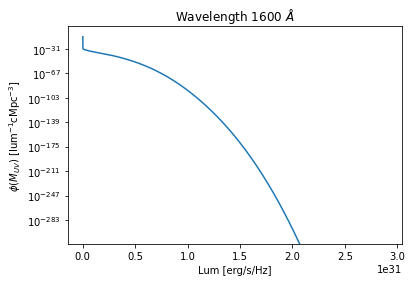

In [7]:
lamda = 1600 #A
z = 1

Lsun = ares.physics.Constants.lsun

Hm = pop_halo.halos.tab_M

# print("L_per_sfr: {}".format(pop.src.L_per_sfr(lamda)))

Lum = pop.src.L_per_sfr(lamda) * 10**pop.SFR(z, Hm, True, log10=False) #[erg/s/Hz]

# print(Lum)

#plotting just lum
# pl.plot(Hm, Lum)
# pl.xlabel('Hm')
# pl.ylabel('Lum [erg/s/Hz]')
# pl.show()

dLdM = dL_dM(z, Lum, Hm)

# print(dLdM)

k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
dndM = pop_halo.halos.tab_dndm[k, :][:-1]
# print(dndM)

LF = dndM/dLdM

# print(LF)

#could put lum in term of lsun = 3.839e33

pl.semilogy(Lum[:-1], LF)

pl.ylabel('$\phi(M_{UV})$ [lum$^{-1}$cMpc$^{-3}$]')
pl.xlabel('Lum [erg/s/Hz]')
pl.title('Wavelength {} $\AA$'.format(lamda))

# pl.ylim(1e-15,)
# pl.ylim(1e-40,1e-18)

pl.show()

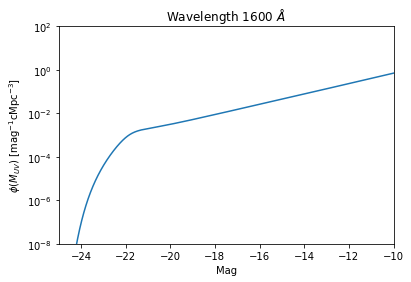

In [8]:
MagSys = ares.util.MagnitudeSystem()
mag = MagSys.L_to_MAB(Lum, z=z)
# print(mag) #all nans for z = 0

dLdM = np.abs(dL_dM(z, mag, Hm))

# print(dLdM)

# k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
# dndM = pop_halo.halos.tab_dndm[k, :][:-1]
# print(dndM)

LF = dndM/dLdM

pl.semilogy(mag[:-1], LF)

pl.ylabel('$\phi(M_{UV})$ [mag$^{-1}$cMpc$^{-3}$]')
pl.xlabel('Mag')
pl.title('Wavelength {} $\AA$'.format(lamda))

# pl.ylim(1e-35,1e-26)
pl.ylim(1e-8,1e2)
pl.xlim(-25,-10)

pl.show()

### Quiescent galaxies  
the key thing we’ll need to know is the age of their stellar populations, or equivalently, the time when these galaxies stopped forming stars. 

To start, perhaps we could parameterize this age in some simple way:   
- assume that the quenching time (or redshift) is a gaussian?   
- Would allow us to say, for a galaxy in a halo of some mass Mh, there’s an X% probability that it quenched at redshift z.   
- Naturally give rise to a distribution of ages, which could be generalized to allow for an mh-dep quenching distribution.


In [35]:
#what are the units/size of this?
# np.random.normal(loc=0.0, scale=1.0, size=None)

#how does it change with Mh?


$M_1 = 10^{logM_0 \cdot (z+1)^{\mu}} \rightarrow M_1 = 10^{logM_0} \cdot (z+1)^{\mu} $
